In [1]:
import numpy as np
import pandas as pd

In [2]:
df_train = pd.read_pickle("./data/data_v2_train.pickle")
X = np.array([list(v) for v in df_train.TFIDF], dtype='float32')
y = np.array([list(l) for l in df_train.label], dtype='float32')
N, x_dim = X.shape
_, n_classes = y.shape
X.shape, y.shape

((11228, 2000), (11228, 34))

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

batch_size = 100
X, y = torch.Tensor(X), torch.tensor(y)
dataset = TensorDataset(X, y)
train_dataset, valid_dataset = random_split(dataset, [10000, 1228])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1228, shuffle=True)

In [5]:
from trainlib import model
from torch import nn
from importlib import reload
reload(model)

model = model.TransformerModel(2002, 168, 4, 256, 2, n_classes, dropout=0.25)
# model = model.DNN([2000, 128, n_classes], dropout=0.25)

Cuda unavailable


Training interrupted at epoch: 0


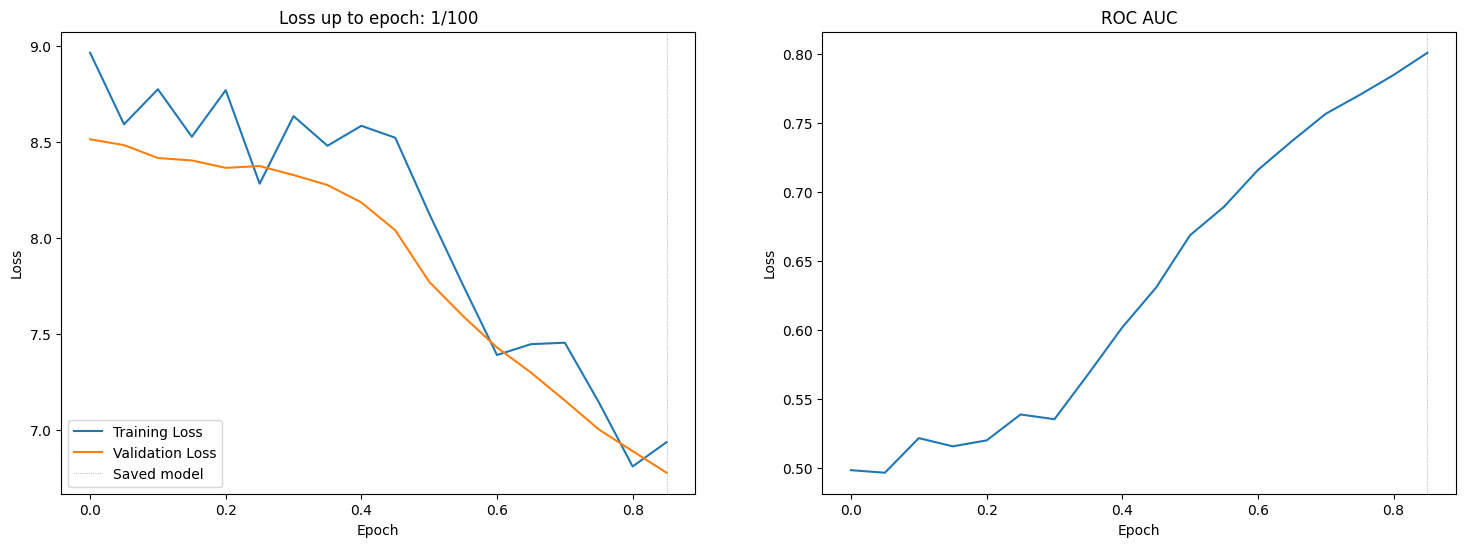

Loaded best model weights!
Total training time: 148.19395232200623 s
Final train loss: 6.936084747314453
Final valid loss: 6.776965141296387


In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score
from trainlib import train
from importlib import reload
reload(train)

n_epochs = 100
batch_logging_freq = 5
metrics = {
    # 'Accuracy': accuracy_score,
    'ROC AUC': roc_auc_score,
}

trainer = train.Trainer(model, epochs=n_epochs, criterion=nn.CrossEntropyLoss(),
                  optim=torch.optim.Adam, lr=1e-3, stopping_batches=25,
                  batch_logging_freq = batch_logging_freq, metrics=metrics,
                  max_grad_norm=2., grad_norm_type=2, lr_factor=.2, lr_patience=10)
trainer.train(train_loader, valid_loader)

In [ ]:
from sklearn.metrics import roc_auc_score

aucs = []
with torch.no_grad():
    for X, y in iter(valid_loader):
        x = model.forward(X).numpy()
        auc = roc_auc_score(y.numpy(), x)
        aucs.append(auc)
np.mean(aucs)

0.6942417782446284

In [ ]:
print("Max AUC:", np.max(trainer.metric_values["ROC AUC"]))

KeyError: 'ROC AUC'